# Implementation of autoencoders

#### First, we will build three convolutional autoencoders, with different size of coding variables. Then, one fully connected autoencoder will be tried out. The model that has the best tradeoff between the loss and the size of coding variables, will be used in the classification task.

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
# Test connection and path to images
!ls "/gdrive/My Drive/computer-vision-project/dataset_resampled"

images	labels	segmentation


In [3]:
!python "/gdrive/My Drive/computer-vision-project/utils.py"

Using TensorFlow backend.


In [4]:
!pip install livelossplot

In [5]:
import keras
from keras import backend as K
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import RMSprop
from livelossplot import PlotLossesKeras
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

Using TensorFlow backend.


In [6]:
#OPTIMIZER=keras.optimizers.Adam()
OPTIMIZER=keras.optimizers.RMSprop()
#LOSS=keras.losses.binary_crossentropy
LOSS=keras.losses.mean_squared_error

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
exec(open('/gdrive/My Drive/computer-vision-project/utils.py').read())

In [0]:
PATH_TO_DATASET = "/gdrive/My Drive/computer-vision-project/dataset_resampled/"
PATH_TO_MODELS = "/gdrive/My Drive/computer-vision-project/models/"

In [9]:
len([img for img in glob.glob(PATH_TO_DATASET + "images/train/*.jpg")])

467

Reading the images for training, validation and test.

In [0]:
x_train = read_train_images()

In [0]:
x_val = read_validation_images()
x_test = read_test_images()

In [0]:
y_train = read_train_labels()
y_val = read_validation_labels()
y_test = read_test_labels()

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[0 1]')

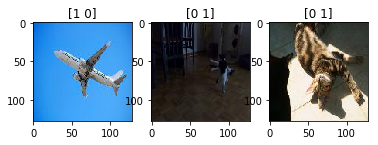

In [14]:
# Display the first image from training data
i=0
plt.subplot(131)
plt.imshow(x_train[i], cmap='gray')
plt.title(y_train[i])

# Display the first image from validation data
plt.subplot(132)
plt.imshow(x_val[i], cmap='gray')
plt.title(y_val[i])

# Display the first image from test data
plt.subplot(133)
plt.imshow(x_test[i], cmap='gray')
plt.title(y_test[i])

In [15]:
print("Training set (images) shape: {shape}".format(shape=x_train.shape))
print("Validation set (images) shape: {shape}".format(shape=x_val.shape))
print("Test set (images) shape: {shape}".format(shape=x_test.shape))

Training set (images) shape: (467, 128, 128, 3)
Validation set (images) shape: (386, 128, 128, 3)
Test set (images) shape: (97, 128, 128, 3)


In [16]:
print("Training set (labels) shape: {shape}".format(shape=y_train.shape))
print("Validation set (labels) shape: {shape}".format(shape=y_val.shape))
print("Test set (labels) shape: {shape}".format(shape=y_test.shape))

Training set (labels) shape: (467, 2)
Validation set (labels) shape: (386, 2)
Test set (labels) shape: (97, 2)


Verification the training and validation data types -> they should be float32.

In [17]:
x_train.dtype, x_val.dtype

(dtype('float32'), dtype('float32'))

Verification that the training and validation data are normalized.

In [18]:
np.max(x_train), np.max(x_val)

(1.0, 1.0)

Define hyperparameters

In [0]:
batch_size = 32    # batch_size = 64 yields larger loss
epochs = 50
inChannel = x_train.shape[3]
x, y = x_train.shape[1], x_train.shape[2]
input_img = Input(shape = (x, y, inChannel))

A Batch normalization was tried out - sfter each convolutiona layer, but it resulted in very high loss.

Define methods for calculation of the reconstruction error.

In [0]:
def get_mse_reconstruction_error(original, output):
  mse_reconstruction_error = mean_squared_error(original.flatten().reshape((original.shape[0],-1)), 
                                    output.flatten().reshape((output.shape[0],-1)))
  return mse_reconstruction_error

def get_mae_reconstruction_error(original, output):
  mae_reconstruction_error = mean_absolute_error(original.flatten().reshape((original.shape[0],-1)), 
                                    output.flatten().reshape((output.shape[0],-1)))
  return mae_reconstruction_error

## Autoencoder with 32 x 32 x 64 coding variables

In [0]:
def encoder(input_img):
    conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img) 
    #conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1) 
    #conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)  
    #conv3 = BatchNormalization()(conv3)
    return conv3

def decoder(conv_layer):
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_layer) 
    #conv4 = BatchNormalization()(conv4)
    up4 = UpSampling2D((2,2))(conv4) 
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(up4)
    #conv5 = BatchNormalization()(conv5)
    up5 = UpSampling2D((2,2))(conv5) 
    decoded = Conv2D(inChannel, (3, 3), activation='sigmoid', padding='same')(up5) 
    return decoded

In [22]:
encoder = encoder(input_img)
print("Shape of code layer", K.int_shape(encoder))
autoencoder_32_32_64 = Model(input_img, decoder(encoder))
autoencoder_32_32_64.compile(loss=LOSS, optimizer = OPTIMIZER)

Shape of code layer (None, 32, 32, 64)


In [23]:
autoencoder_32_32_64.summary()
# from keras.utils.vis_utils import plot_model
# plot_model(autoencoder_32_32_128, to_file='1_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 256)     7168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       295040    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
__________

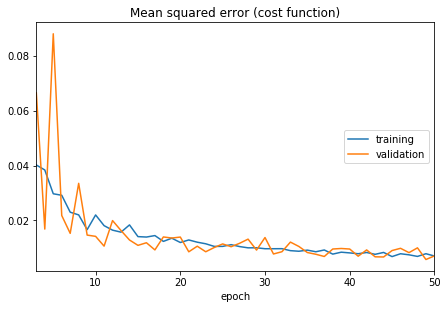

Mean squared error (cost function):
training   (min:    0.007, max:    0.103, cur:    0.007)
validation (min:    0.006, max:    0.088, cur:    0.007)


In [24]:
autoencoder_train_32_32_64 = autoencoder_32_32_64.fit(x_train, 
                                                      x_train, 
                                                      batch_size=batch_size,
                                                      epochs=epochs,
                                                      verbose=1,
                                                      validation_data=(x_val, x_val),
                                                      callbacks=[PlotLossesKeras()])

In [25]:
print('Loss: ' + str(np.mean(autoencoder_train_32_32_64.history['loss'])))
print('Validtion Loss: ' + str(np.mean(autoencoder_train_32_32_64.history['val_loss'])))


Loss: 0.015893366026913453
Validtion Loss: 0.01600251472555101


In [0]:
output_32_32_64 = autoencoder_32_32_64.predict(x_test)


In [27]:
print('MSE reconstruction error for Autoencoder_32_32_64 = %.5f' % get_mse_reconstruction_error(x_test, output_32_32_64))
print('MAE reconstruction error for Autoencoder_32_32_64 = %.5f' % get_mae_reconstruction_error(x_test, output_32_32_64))

MSE reconstruction error for Autoencoder_32_32_64 = 0.00646
MAE reconstruction error for Autoencoder_32_32_64 = 0.06150


## Autoencoder with 16 x 16 x 32 coding variables

In [0]:
def encoder(input_img):
    conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img) 
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2) 
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv3) 
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2) 
    return conv4

def decoder(conv_layer):
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_layer) 
    up1 = UpSampling2D((2,2))(conv4) 
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv5) 
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up2)
    up3 = UpSampling2D((2,2))(conv6) 
    decoded = Conv2D(inChannel, (3, 3), activation='sigmoid', padding='same')(up3) 
    return decoded

In [29]:
encoder = encoder(input_img)
print("Shape of code layer", K.int_shape(encoder))
autoencoder_16_16_32 = Model(input_img, decoder(encoder))
autoencoder_16_16_32.compile(loss=LOSS, optimizer = OPTIMIZER)

Shape of code layer (None, 16, 16, 32)


In [30]:
autoencoder_16_16_32.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 256)     7168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 128)       295040    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
__________

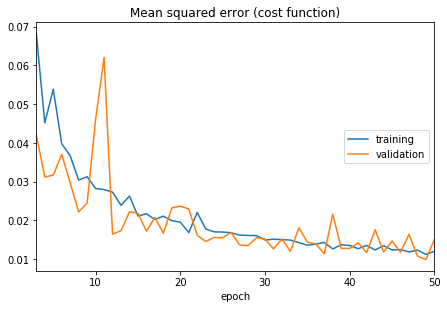

Mean squared error (cost function):
training   (min:    0.011, max:    0.092, cur:    0.012)
validation (min:    0.010, max:    0.068, cur:    0.015)


In [31]:
autoencoder_train_16_16_32 = autoencoder_16_16_32.fit(x_train, 
                                                      x_train, 
                                                      batch_size=batch_size,
                                                      epochs=epochs,
                                                      verbose=1,
                                                      validation_data=(x_val, x_val),
                                                      callbacks=[PlotLossesKeras()])

In [32]:
print('Loss: ' + str(np.mean(autoencoder_train_16_16_32.history['loss'])))
print('Validtion Loss: ' + str(np.mean(autoencoder_train_16_16_32.history['val_loss'])))


Loss: 0.023390718850544487
Validtion Loss: 0.02159536255113395


In [0]:
output_16_16_32 = autoencoder_16_16_32.predict(x_test)

In [34]:
print('MSE reconstruction error for Autoencoder_16_16_32 = %.5f' % get_mse_reconstruction_error(x_test, output_16_16_32))
print('MAE reconstruction error for Autoencoder_16_16_32 = %.5f' % get_mae_reconstruction_error(x_test, output_16_16_32))

MSE reconstruction error for Autoencoder_16_16_32 = 0.01468
MAE reconstruction error for Autoencoder_16_16_32 = 0.09354


## Autoencoder with 8 x 8 x 16 coding variables

In [0]:
def encoder_8_8_16(input_img):
    conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img) 
    #conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1) 
    #conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    #conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) 
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool3) 
    #conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4) 
    conv5 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool4) 
    #conv5 = BatchNormalization()(conv5)
    return conv5

def decoder_8_8_16(conv_layer):
    conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv_layer) 
    #conv6 = BatchNormalization()(conv6)
    up2 = UpSampling2D((2,2))(conv6) 
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2) 
    #conv7 = BatchNormalization()(conv7)
    up3 = UpSampling2D((2,2))(conv7) 
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3) 
    #conv8 = BatchNormalization()(conv8)
    up4 = UpSampling2D((2,2))(conv8) 
    conv9 = Conv2D(256, (3, 3), activation='relu', padding='same')(up4)
    #conv9 = BatchNormalization()(conv9)
    up5 = UpSampling2D((2,2))(conv9) 
    conv8 = Conv2D(inChannel, (3, 3), activation='sigmoid', padding='same')(up5) 
    return conv8
    

In [57]:
encode = encoder_8_8_16(input_img)
print("Shape of code layer", K.int_shape(encode))
autoencoder_8_8_16 = Model(input_img, decoder_8_8_16(encode))
autoencoder_8_8_16.compile(loss=LOSS, optimizer=OPTIMIZER)
autoencoder_8_8_16.summary()

Shape of code layer (None, 8, 8, 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 256)     7168      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 128)       295040    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16,

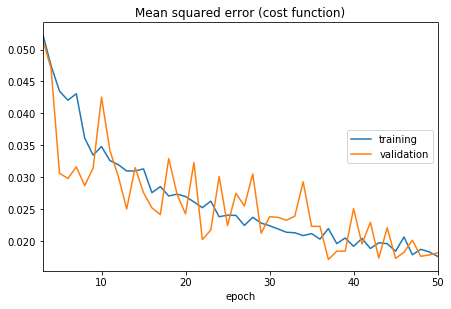

Mean squared error (cost function):
training   (min:    0.018, max:    0.088, cur:    0.018)
validation (min:    0.017, max:    0.268, cur:    0.018)


In [58]:
autoencoder_train_8_8_16 = autoencoder_8_8_16.fit(x_train, 
                                                  x_train, 
                                                  batch_size=batch_size,
                                                  epochs=50,
                                                  verbose=1,
                                                  validation_data=(x_val, x_val),
                                                  callbacks=[PlotLossesKeras()])

In [38]:
print('Loss: ' + str(np.mean(autoencoder_train_8_8_16.history['loss'])))
print('Validtion Loss: ' + str(np.mean(autoencoder_train_8_8_16.history['val_loss'])))

Loss: 0.020037696211453234
Validtion Loss: 0.04363149853239868


In [0]:
output_8_8_16 = autoencoder_8_8_16.predict(x_test)

In [40]:
print('MSE reconstruction error for Autoencoder_8_8_16 = %.5f' % get_mse_reconstruction_error(x_test, output_8_8_16))
print('MAE reconstruction error for Autoencoder_8_8_16 = %.5f' % get_mae_reconstruction_error(x_test, output_8_8_16))

MSE reconstruction error for Autoencoder_8_8_16 = 0.02647
MAE reconstruction error for Autoencoder_8_8_16 = 0.11952


## Deep autoencoder
- Fully connected layers
- Using flattened images
- Setting the encoding size: if the size is 32, we do a compression of factor 1536 (assuming flattend input image size of 49152)

In [0]:
x_resh = x_train[0].reshape(-1)
flaten_input = x_resh.shape
flat_input_img = Input(shape=flaten_input)
encoding_size = 32

In [0]:
x_train_flat = np.array([img.reshape(-1) for img in x_train])
x_val_flat = np.array([img.reshape(-1) for img in x_val])
x_test_flat = np.array([img.reshape(-1) for img in x_test])

In [0]:
def encoder(input_img):
  encoded = Dense(128, activation='relu')(input_img)
  encoded = Dense(64, activation='relu')(encoded)
  encoded = Dense(encoding_size, activation='relu')(encoded)
  return encoded

def decoder(encoded):
  decoded = Dense(64, activation='relu')(encoded)
  decoded = Dense(128, activation='relu')(decoded)
  decoded = Dense(flaten_input[0], activation='sigmoid')(decoded)
  return decoded

In [44]:
deep_encoder = encoder(flat_input_img)
autoencoder_deep = Model(flat_input_img, decoder(deep_encoder))
autoencoder_deep.compile(optimizer=OPTIMIZER, loss=LOSS)
autoencoder_deep.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 49152)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               6291584   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 49152)             6340608   
Total para

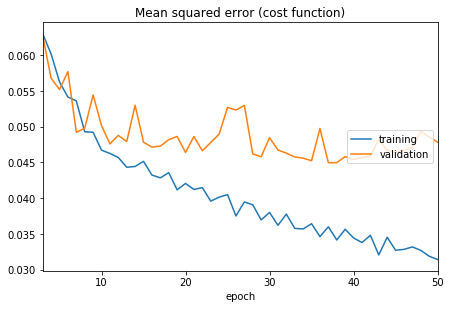

Mean squared error (cost function):
training   (min:    0.031, max:    0.073, cur:    0.031)
validation (min:    0.045, max:    0.068, cur:    0.048)


In [45]:
autoencoder_train_deep = autoencoder_deep.fit(x_train_flat, 
                                              x_train_flat,
                                              epochs=epochs,
                                              batch_size=batch_size,
                                              validation_data=(x_val_flat, x_val_flat),
                                              callbacks=[PlotLossesKeras()])

In [46]:
print('Loss: ' + str(np.mean(autoencoder_train_deep.history['loss'])))
print('Validtion Loss: ' + str(np.mean(autoencoder_train_deep.history['val_loss'])))

Loss: 0.04183934948022219
Validtion Loss: 0.049584546656651816


In [0]:
output_deep = autoencoder_deep.predict(x_test_flat)
output_deep_resh = output_deep.reshape(-1,x,y,inChannel)

In [48]:
print('MSE reconstruction error for Autoencoder_deep = %.5f' % get_mse_reconstruction_error(x_test, output_deep_resh))
print('MAE reconstruction error for Autoencoder_deep = %.5f' % get_mae_reconstruction_error(x_test, output_deep_resh))

MSE reconstruction error for Autoencoder_deep = 0.04296
MAE reconstruction error for Autoencoder_deep = 0.16005


#### Now, let's test how the autoencoders reconstruct the images.

In [0]:
def plot_reconstructed_images(i):
    plt.subplot(151)
    plt.title('Original')
    plt.imshow(x_test[i], cmap='gray')
    plt.axis("off")
    plt.subplot(152)
    plt.title('32_32_128')
    plt.imshow(output_32_32_64[i], cmap='gray')
    plt.axis("off")
    plt.subplot(153)
    plt.title('16_16_32')
    plt.imshow(output_16_16_32[i], cmap='gray')
    plt.axis("off")
    plt.subplot(154)
    plt.title('8_8_16')
    plt.imshow(output_8_8_16[i], cmap='gray')
    plt.axis("off")
    plt.subplot(155)
    plt.title('deep')
    plt.imshow(output_deep_resh[i], cmap='gray')
    plt.axis("off")

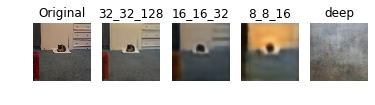

In [50]:
i = 12
plot_reconstructed_images(i)

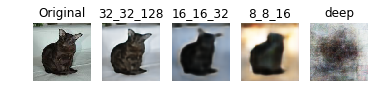

In [51]:
i = 15
plot_reconstructed_images(i)

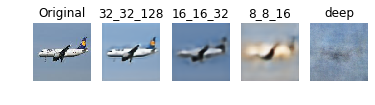

In [52]:
i = 40
plot_reconstructed_images(i)

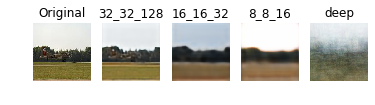

In [53]:
i = 30
plot_reconstructed_images(i)

In [54]:
save_model(autoencoder_16_16_32, 'autoencoder_16_16_32')

Saved model to disk


In [55]:
save_model(autoencoder_32_32_64, 'autoencoder_32_32_64')

Saved model to disk
